# Notebook 8: Classification using OpenCV Modeling and CNN 

#### Training
* The Machine Learning Algorithm is trained using Spectrum Images generated using OpenCV Preprocessing.
* The Spectrum Images are converted to Arrays and then concatenated.
* The Model is trained from the concatenated arrays.

### Setting up working directory:

In [1]:
AED_C_dir = 'ESC50/Dataset'

### Importing necessary libraries:

In [2]:
import pandas as pd
import h5py
import os
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import librosa
import cv2
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import seaborn as sn

2022-09-29 21:47:28.923174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sumon/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-09-29 21:47:28.923200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Reading the Metadata file and displaying the headers:

In [3]:
meta_data = pd.read_csv(AED_C_dir+'/metadata.csv')
meta_data.head()

,Unnamed: 0,filename,fold,target,category,esc10,src_file,take
0,3,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
1,4,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
2,40,1-155858-A-25.wav,1,25,footsteps,False,155858,A
3,41,1-155858-B-25.wav,1,25,footsteps,False,155858,B
4,42,1-155858-C-25.wav,1,25,footsteps,False,155858,C


### Preparing the data for Modeling 

In [4]:
save_loc = 'ESC50/Dataset/Dataset_image/'
images = []
labels = []
unique_labels = meta_data['category'].unique()
for i in range(len(meta_data)):
        name = meta_data['filename'][i].split('.')[0]
        a = cv2.resize(cv2.imread(save_loc+'E_'+name+'.jpg'), (64, 64))
        b = cv2.resize(cv2.imread(save_loc+'f_tract_'+name+'.jpg'), (64, 64))
        c = cv2.resize(cv2.imread(save_loc+'s_tract_'+name+'.jpg'), (64, 64))
        images.append(np.vstack((a.T, b.T, c.T)).T) #Concatenating image arrays.
        labels.append(np.where(unique_labels == meta_data['category'][i])[0][0])
images = np.array(images)
images = images.astype('float32') / 255
labels = to_categorical(np.array(labels))

### Dividing the data into training and testing sets:

In [5]:
train_images, val_images, train_labels, val_labels = train_test_split(
                                             images, labels, train_size = 0.85, 
                                             test_size = 0.15, random_state = 42)

In [6]:
len(train_labels), len(val_labels)

(306, 54)

###  Machine Learning Modelling:

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding ='same',
                 input_shape=(64, 64, 9)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding ='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation = 'softmax'))
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6), loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2624      
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                        

2022-09-29 21:47:30.410385: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-29 21:47:30.410412: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sumonpc): /proc/driver/nvidia/version does not exist
2022-09-29 21:47:30.410884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/sumon/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Model Fitting

In [8]:
history = model.fit(train_images, train_labels, epochs = 80, batch_size = 64)

Epoch 1/80
5/5 [==============================] - 2s 317ms/step - loss: 2.2645 - accuracy: 0.0915
Epoch 2/80
5/5 [==============================] - 2s 313ms/step - loss: 2.2065 - accuracy: 0.1928
Epoch 3/80
5/5 [==============================] - 2s 327ms/step - loss: 2.0415 - accuracy: 0.2418
Epoch 4/80
5/5 [==============================] - 2s 315ms/step - loss: 1.9703 - accuracy: 0.2157
Epoch 5/80
5/5 [==============================] - 2s 313ms/step - loss: 1.8130 - accuracy: 0.2941
Epoch 6/80
5/5 [==============================] - 2s 320ms/step - loss: 1.9226 - accuracy: 0.2582
Epoch 7/80
5/5 [==============================] - 2s 320ms/step - loss: 1.7632 - accuracy: 0.2876
Epoch 8/80
5/5 [==============================] - 2s 322ms/step - loss: 1.5906 - accuracy: 0.3627
Epoch 9/80
5/5 [==============================] - 2s 334ms/step - loss: 1.8540 - accuracy: 0.3203
Epoch 10/80
5/5 [==============================] - 2s 324ms/step - loss: 1.6672 - accuracy: 0.3725
Epoch 11/80
5/5 [==

### Evaluation
#### Accuracy, Model Evaluation Plot and Confusion Matrix:

In [9]:
def con_matrix(y_test, y_predict):
    cm = confusion_matrix(y_test, y_predict, normalize="true")*100
    plt.figure(figsize = (10,7))
    df=pd.DataFrame(cm, index = unique_labels)
    df.columns = unique_labels
    sn.heatmap(df, annot = True)
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

#### Model Evaluation Plot

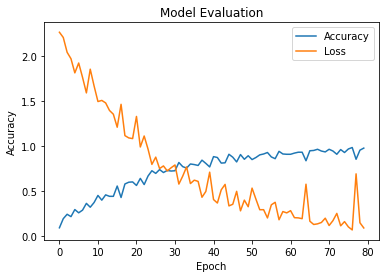

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Evaluation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc = 'upper right')
plt.show()

#### Confusion Matrix

2/2 [==============================] - 0s 17ms/step
Accuracy: 75.92592592592592 %


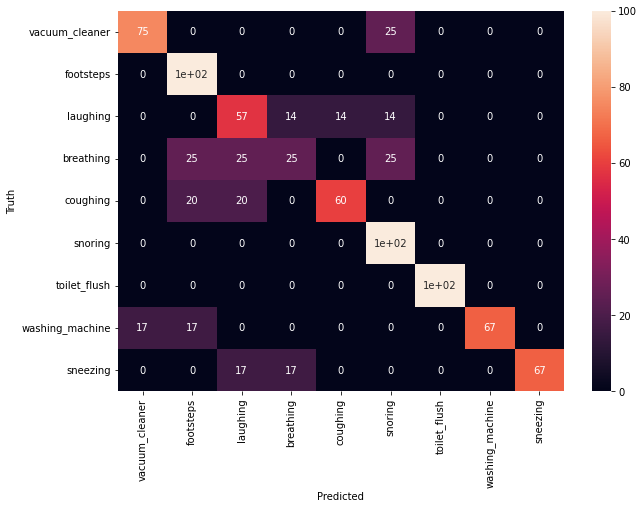

In [11]:
pred = model.predict(val_images)
predicted_class_indices = np.argmax(pred, axis = 1)
y_test = np.argmax(val_labels, axis = 1)
acc = accuracy_score(predicted_class_indices, y_test)
print('Accuracy:', acc*100,'%')
con_matrix(y_test, predicted_class_indices)